[Reference](https://towardsdatascience.com/distance-metric-learning-for-outlier-detection-5b4840d01246)

In [1]:
import numpy as np
import pandas as pd

def create_simple_testdata():
    np.random.seed(0)
    a_data = np.random.normal(size=100)
    b_data = np.random.normal(size=100)
    df = pd.DataFrame({"A": a_data, "B": b_data})
    return df

In [2]:
def create_four_clusters_test_data():
    np.random.seed(0)

    a_data = np.random.normal(loc=25.0, scale=2.0, size=5)
    b_data = np.random.normal(loc=4.0, scale=2.0, size=5)
    df0 = pd.DataFrame({"A": a_data, "B": b_data})

    a_data = np.random.normal(loc=1.0, scale=2.0, size=50)
    b_data = np.random.normal(loc=19.0, scale=2.0, size=50)
    df1 = pd.DataFrame({"A": a_data, "B": b_data})

    a_data = np.random.normal(loc=1.0, scale=1.0, size=200)
    b_data = np.random.normal(loc=1.0, scale=1.0, size=200)
    df2 = pd.DataFrame({"A": a_data, "B": b_data})

    a_data = np.random.normal(loc=20.0, scale=3.0, size=500)
    b_data = np.random.normal(loc=13.0, scale=3.0, size=500) + a_data
    df3 = pd.DataFrame({"A": a_data, "B": b_data})

    outliers = [[5.0, 40],
                [1.5, 8.0],
                [11.0, 0.5]]
    df4 = pd.DataFrame(outliers, columns=['A', 'B'])

    df = pd.concat([df0, df1, df2, df3, df4])
    df = df.reset_index(drop=True)
    return df

In [3]:
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.preprocessing import RobustScaler

class DMLOutlierDetection:
    def __init__(self):
        pass

    def fit_predict(self, df):
        real_df = df.copy()
        real_df['Real'] = True

        # Generate synthetic data that is similar to the real data
        # For simplicity, this covers just the numeric case.
        synth_df = pd.DataFrame()
        for col_name in df.columns:
            mean = df[col_name].mean()
            stddev = df[col_name].std()
            synth_df[col_name] = np.random.normal(loc=mean,
               scale=stddev, size=len(df))
        synth_df['Real'] = False

        train_df = pd.concat([real_df, synth_df])

        clf = RandomForestClassifier(max_depth=5)
        clf.fit(train_df.drop(columns=['Real']), train_df['Real'])

        # Get the leaf node each record ends in
        r = clf.apply(df)

        # Initialize the score for all records to 0
        scores = [0]*len(df)

        # Loop through each tree in the Random Forest
        for tree_idx in range(len(r[0])):
            # Get the count of each leaf node
            c = Counter(r[:, tree_idx])

            # Loop through each record and update its score based
            # on the frequency of the node it ends in
            for record_idx in range(len(df)):
                node_idx = r[record_idx, tree_idx]
                node_count = c[node_idx]
                scores[record_idx] += len(df) - node_count

        return scores

df = create_four_clusters_test_data()
df = pd.DataFrame(RobustScaler().fit_transform(df), columns=df.columns)
clf = DMLOutlierDetection()
df['Scores'] = clf.fit_predict(df)

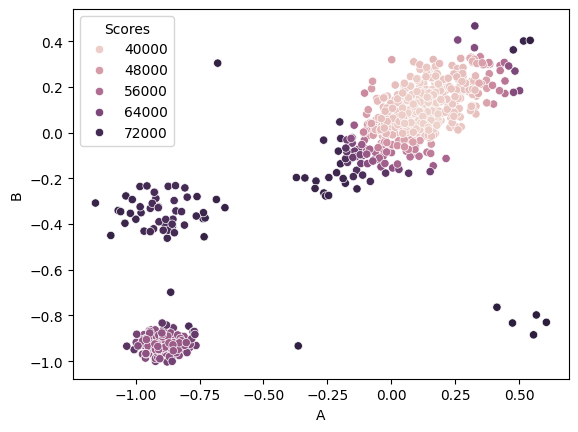

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=df["A"], y=df['B'], hue=df['Scores'])
plt.show()